<a name="top" id="top"></a>

<div align="center">

<h1>PSO 4:  PID controller tuning using the Process Reaction Curve based Ziegler Nichols approximate model approach</h1>

<p>
  <a href="https://github.com/bernalde"><strong>David E. Bernal Neira</strong></a><br>
  <em>Davidson School of Chemical Engineering, Purdue University</em><br>
  <em>Universities Space Research Association</em><br>
  <em>NASA QuAIL</em>
</p>

<br>

<p>
  <a href="https://github.com/mhuertasm"><strong>Mateo Huertas Marulanda</strong></a><br>
  <em>Chemical Engineering, National University of Colombia</em><br>
  <em>Undergraduate Visiting Scholar</em>
</p>

<br>

<p>
  <a href="https://colab.research.google.com" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
  </a>
  <a href="https://secquoia.github.io/">
    <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA">
  </a>
</p>

</div>


## 🎯 Objective

In this exercise, we apply the Process Reaction Curve method to approximate the dynamics of a third-order system using an FOPTD model. We then use the **Ziegler-Nichols** tuning rules to calculate the PID controller parameters, and simulate the closed-loop performance. The goal is to compare the controller performance using the **FOPTD** approximation and the **system's actual response**.

## 💻 Code Purpose

This code:

1. Defines the original system and its corresponding FOPTD model and compares the two.
2. Calculates the PID controller parameters using the Ziegler-Nichols tuning rules.
3. Simulates the closed-loop performance using the calculated PID parameters and compares the results with the system's response.

## 🔑 Key Concepts

### **Padé Approximation**

The **Padé approximation** is a method used to approximate time delays in transfer functions. It is especially useful when dealing with systems that involve time delays, which are often hard to model directly. In this exercise, we use the **Padé approximation** to represent the time delay in the FOPTD model. The transfer function for the **Padé approximation** of a time delay $\theta$ is given by:

$$
e^{-\theta s} \approx \frac{1 - \frac{\theta s}{2}}{1 + \frac{\theta s}{2}}
$$

This approximation converts the delay term into a rational transfer function, making it easier to analyze and simulate in control systems. In the code, we use this approximation to model the time delay component of the system in the **FOPTD model**.

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# Define the original transfer functions

In [2]:
num = [6]
den = [2, 1]
sys = ct.TransferFunction(num, den)

num1 = [1]
den1 = [4, 1]
sys1 = ct.TransferFunction(num1, den1)

num2 = [1]
den2 = [6, 1]
sys2 = ct.TransferFunction(num2, den2)

# Total system: multiplication of the three transfer functions
systotal = sys * sys1 * sys2

# Define the FOPTD model  

In [3]:
# Parameters of the First Order Plus Time Delay (FOPTD) model
K = 6       # Effective system gain
tau = 9     # Effective time constant (seconds)
theta = 3.5 # Effective time delay (seconds)
# First-order system without delay: K / (tau s + 1)
num_foptd = [K]          # Numerator of the first-order model
den_foptd = [tau, 1]     # Denominator of the first-order model
foptd_dynamics = ct.TransferFunction(num_foptd, den_foptd)  # First-order transfer function

# Define the time delay aproximation

In [4]:
# First-order Padé approximation for modeling the time delay theta
num_pade = [-theta/2, 1]  # Numerator of the Padé approximation
den_pade = [theta/2, 1]   # Denominator of the Padé approximation
delay_approx = ct.TransferFunction(num_pade, den_pade)  # Transfer function for the time delay

# Complete the FOPTD model with delay

In [5]:
foptd_total = foptd_dynamics * delay_approx  # Multiply dynamics with delay approximation

# Define the time array

In [6]:
# Time vector for simulation
t = np.linspace(0, 50, 1000)

# Simulate system responses

In [7]:
t1, y1 = ct.step_response(systotal, t)  # Normal system response
t2, y2 = ct.step_response(foptd_total, t)  # FOPTD model response


# Plot both responses

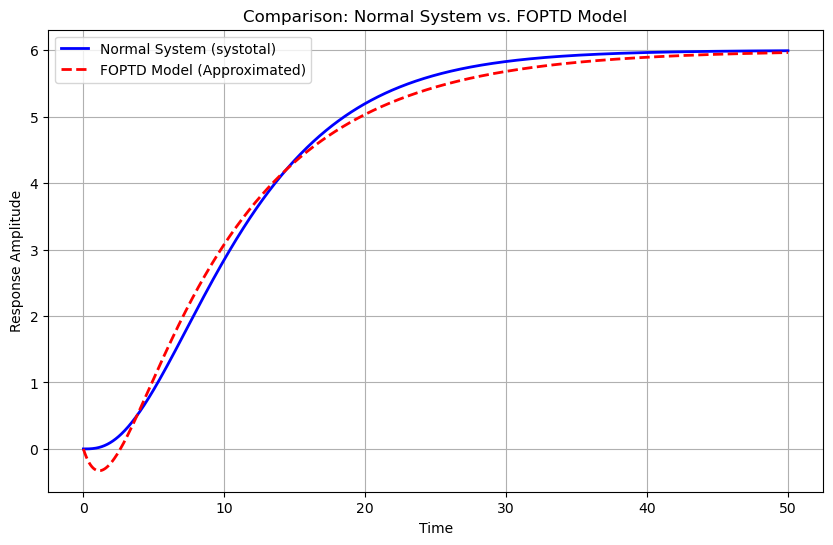

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t1, y1, label='Normal System (systotal)', color='b', linewidth=2)
plt.plot(t2, y2, label='FOPTD Model (Approximated)', color='r', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Response Amplitude')
plt.title('Comparison: Normal System vs. FOPTD Model')
plt.legend()
plt.grid(True)
plt.show()


# Define the parameters for both PID controllers

In [9]:
# PID PARAMETERS FROM EXERCISE 1 (Based on Ziegler-Nichols tuning method)
Ku = 1.67          # Ultimate gain
Tu = 12.7          # Ultimate period
Kp_1 = 0.6 * Ku      # Proportional gain
Ti = 0.5 * Tu      # Integral time constant
Td = 0.125 * Tu    # Derivative time constant

Ki_1 = Kp_1 / Ti       # Integral gain
Kd_1 = Kp_1 * Td       # Derivative gain

# PID PARAMETERS FOR CURRENT EXERCISE (FOPTD)
K = 6       # Effective system gain
tau = 9     # Effective time constant (seconds)
theta = 3.5 # Effective time delay (seconds)

Kp = (1.2 * tau) / (K * theta)  # Proportional gain for FOPTD
Ti = 2 * theta                   # Integral time constant for FOPTD
Td = 0.5 * theta                 # Derivative time constant for FOPTD
Ki = Kp / Ti                     # Integral gain for FOPTD
Kd = Kp * Td                     # Derivative gain for FOPTD

# Define the PID controllers

In [10]:
# Define the PID controller transfer function for FOPTD
pid_controller_ZN = ct.TransferFunction([Kd, Kp, Ki], [1, 0])
pid_controller_FOPTD = ct.TransferFunction([Kd_1, Kp_1, Ki_1], [1, 0])

# Define the closed loop systems

In [11]:
sys_open_loop_1 = ct.series(pid_controller_ZN, systotal)  # Series connection of PID and system
sys_closed_loop_1 = ct.feedback(sys_open_loop_1, 1)  # Feedback connection to create closed-loop system

# Closed-loop system with PID for FOPTD model
sys_open_loop_2 = ct.series(pid_controller_FOPTD, systotal)  # Series connection of PID and system
sys_closed_loop_2 = ct.feedback(sys_open_loop_2, 1)  # Feedback connection to create closed-loop system


# Simulate the step responses

In [12]:
# Simulate the step response for the PID controller in the FOPTD model
t_cl, y_cl_pid = ct.step_response(sys_closed_loop_2, t)


# Simulate the step response for the PID controller in Exercise 1
t1, y1_pid = ct.step_response(sys_closed_loop_1, t)

# Plot both PID responses 

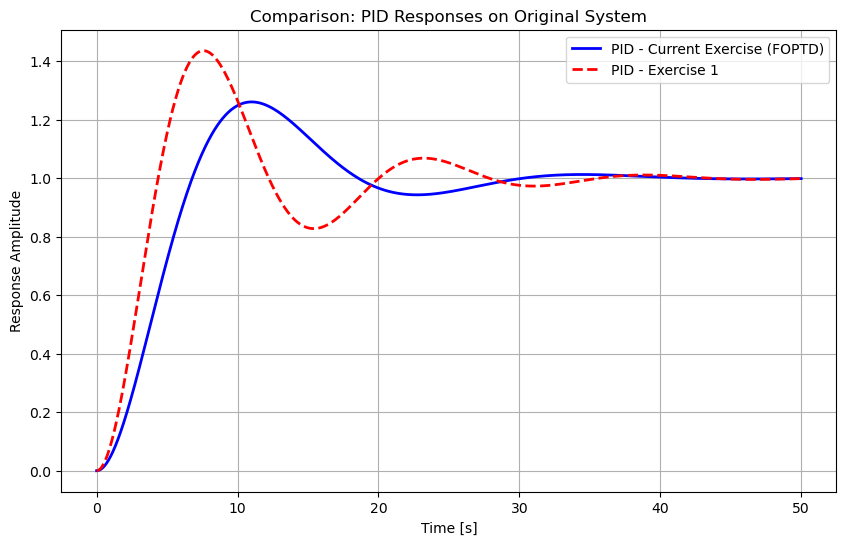

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(t1, y1_pid, label='PID - Current Exercise (FOPTD)', color='b', linewidth=2)
plt.plot(t_cl, y_cl_pid, label='PID - Exercise 1', color='r', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Time [s]')
plt.ylabel('Response Amplitude')
plt.title('Comparison: PID Responses on Original System')
plt.legend()
plt.grid(True)
plt.show()

---

## ✅ Conclusions: 

In this exercise, we analyzed two key aspects of controller performance:

- **PID Response Comparison**:  
  - The PID controller tuned using the FOPTD (First Order Plus Dead Time) model produced a faster and less oscillatory response compared to the PID controller tuned in Exercise 1.
  - Although both controllers ultimately stabilized around the setpoint, the FOPTD-based tuning achieved better transient behavior, with reduced overshoot and faster settling time.
  - This demonstrates the effectiveness of tuning based on a simplified dynamic model when properly identified.

- **System vs FOPTD Model Approximation**:  
  - Comparing the original third-order system with its FOPTD approximation showed good agreement, especially during the early and mid-term response phases.
  - The FOPTD model slightly underestimates the system response at steady-state but captures the dominant dynamics effectively.
  - This validates the use of simple approximations like FOPTD for PID tuning, offering a balance between model simplicity and control performance.
  - **FOPTD approximations** are reliable for designing controllers when full system dynamics are complex or unknown.

The exercise highlights how **model-based tuning strategies** can enhance controller performance even when working with approximated system representations.

---
